In [180]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
import pandas as pd

import emcee

import pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (32, 20)

In [73]:
#program params
no_runs=10
zboundry=0.51

cent_bin_edges=np.linspace(12.28,16.04,48)
cent_bin_cents=cent_bin_edges[1:]-(cent_bin_edges[1]-cent_bin_edges[0])/2.
#sat_bin_edges=np.linspace(,15.7,10)
#sat_bin_cents=sat_bin_edges[1:]-(sat_bin_edges[1]-sat_bin_edges[0])/2.

#load data
dataM,dataP=np.loadtxt('/home/swb1g09/Clustering_project/dpdlgm_mcmc_dr10_z0.400.60_ms11.5.dat', usecols=(0,2),unpack=True,skiprows=1)
datasatP=np.loadtxt('/home/swb1g09/Clustering_project/dpdlgm_mcmc_dr10_z0.400.60_ms11.5.dat', usecols=(3,),unpack=True,skiprows=1)

ss=(np.arange(0,47)%2).astype(bool)
dataM_sats=dataM[ss]
dataP_sats=datasatP[ss]
sat_bin_cents=dataM_sats
dif=sat_bin_cents[1]-sat_bin_cents[0]
sat_bin_edges=sat_bin_cents-dif/2.
sat_bin_edges=np.append(sat_bin_edges,[sat_bin_edges[-1]+dif])

print(len(dataM_sats))
print(len(sat_bin_cents))
print(len(sat_bin_edges))

#load redshift steps
a,z=np.loadtxt('/home/swb1g09/Bolshoi_stuff/all_catalogues/db_haloes/a.list',usecols=(0,1),skiprows=1,unpack=True,delimiter=',')

#load halo catalogues
Cents=pd.read_csv('/home/swb1g09/Clustering_project/PerViola_zCen0.5_new.dat',delim_whitespace=True)
Sats=pd.read_csv('/home/swb1g09/Clustering_project/PerViola_zSatParent0.5_new3.dat',delim_whitespace=True)

#clean up the halo catalogues

Cents['M200b']/=0.7
Cents['M200c']/=0.7

Sats['M200b']/=0.7
Sats['M200c']/=0.7
Sats['M200b_inf']/=0.7
Sats['M200c_inf']/=0.7
Sats['M200b_host']/=0.7
Sats['M200c_host']/=0.7

23
23
24


In [74]:
print(dataM)
print(cent_bin_cents)
print(sat_bin_cents)

[ 12.32  12.4   12.48  12.56  12.64  12.72  12.8   12.88  12.96  13.04
  13.12  13.2   13.28  13.36  13.44  13.52  13.6   13.68  13.76  13.84
  13.92  14.    14.08  14.16  14.24  14.32  14.4   14.48  14.56  14.64
  14.72  14.8   14.88  14.96  15.04  15.12  15.2   15.28  15.36  15.44
  15.52  15.6   15.68  15.76  15.84  15.92  16.  ]
[ 12.32  12.4   12.48  12.56  12.64  12.72  12.8   12.88  12.96  13.04
  13.12  13.2   13.28  13.36  13.44  13.52  13.6   13.68  13.76  13.84
  13.92  14.    14.08  14.16  14.24  14.32  14.4   14.48  14.56  14.64
  14.72  14.8   14.88  14.96  15.04  15.12  15.2   15.28  15.36  15.44
  15.52  15.6   15.68  15.76  15.84  15.92  16.  ]
[ 12.4   12.56  12.72  12.88  13.04  13.2   13.36  13.52  13.68  13.84  14.
  14.16  14.32  14.48  14.64  14.8   14.96  15.12  15.28  15.44  15.6
  15.76  15.92]


In [75]:
def Moster13(M,z,gamma0,sigma):   
    m1=10**(11.59+1.195*(z/(1.+z)))
    N=0.0351-0.0247*(z/(1.+z))
    beta=1.376-0.826*(z/(1.+z))                   
    gamma=gamma0+0.329*(z/(1.+z))
    return (M*2.*N/((M/m1)**-beta+(M/m1)**gamma))*10**np.random.normal(0.,sigma,len(M))



In [76]:
#this defines the boundry where at high z where a satellite will be an LRG at z=0

m_sat_boundry=np.ones(len(z))*11.45
d={'BoundryMass' : m_sat_boundry, 'z_inf': z}
Boundry=pd.DataFrame(d)

Sats=pd.merge(Sats,Boundry,right_on='z_inf',left_on='z_inf',sort=False,copy=False,how='left')


In [140]:
def model(gamma05,gamma,sigma05,sigma):
    #print("start")
    cent_P=[np.zeros(len(cent_bin_cents))]
    sat_P=[np.zeros(len(sat_bin_cents))]
    satfrat=0
    ncen=0
    nsat=0

    for i in range(0,no_runs):
        Sats.loc[Sats.z_inf >= zboundry, 'gamma'] = gamma05
        Sats.loc[Sats.z_inf < zboundry, 'gamma'] =  gamma
        Cents.loc[:,'mstar']=pd.Series(Moster13(Cents['M200c'].values,0.5052306766,gamma,sigma),index=Cents.index)
        #Cents.loc[:,'mstar']=pd.Series(Moster13(Cents['M_vir_inf'].values,Cents['z_inf'].values,0.4,0.15),index=Cents.index)
        Sats.loc[:,'mstar']=pd.Series(Moster13(Sats['M200c_inf'].values,Sats['z_inf'].values,Sats['gamma'].values,sigma),index=Sats.index)
        Cents_LRGs=Cents.query('mstar > 10**11.45')
        Sats_LRGs=Sats.query('mstar > 10**BoundryMass')
        if len(Cents_LRGs.index)>0:
            ncen+=len(Cents_LRGs.index)
            p=np.histogram(np.log10(Cents_LRGs['M200b'].values),bins=cent_bin_edges,density=False)[0]
            norm=1./(cent_bin_edges[1]-cent_bin_edges[0])/np.sum(p)
            if(np.sum(p))==0:
                print(np.sum(m_star_cents>11.5), p, norm, Cents_LRGs['Mstar'], Cents_LRG['M_vir_inf'])
            cent_P=np.append(cent_P,[(p*norm)],axis=0)

            if len(Sats_LRGs.index)>0:  
                q=np.histogram(np.log10(Sats_LRGs['M200b_host'].values),bins=sat_bin_edges,density=False)[0]
                #print(len(sat_P[0]))
                #print(len([q*norm][0]))                
                sat_P=np.append(sat_P,[q*norm],axis=0)
                satfrat+=float(np.sum(q))/float(np.sum(p))
                nsat+=len(Sats_LRGs.index)
            else:

                sat_P=np.append(sat_P,[np.zeros(len(sat_bin_cents))],axis=0)   
    return cent_P.sum(axis=0)/no_runs,sat_P.sum(axis=0)/no_runs,cent_P.std(axis=0),sat_P.std(axis=0)

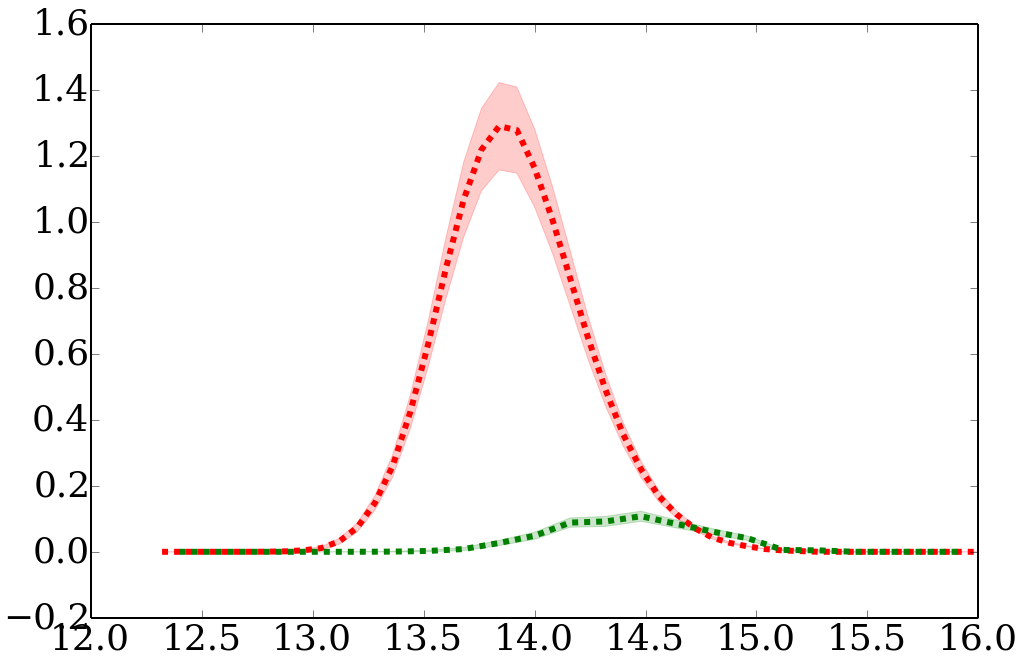

In [141]:
sel_color='r'
sel_color2='g'

cents_mean,sats_mean,cents_std,sats_std=model(0.5,0.5,0.1,0.1)
plt.plot(cent_bin_cents,cents_mean,linestyle="--",color=sel_color,label=1-0.5)
plt.fill_between(cent_bin_cents,cents_mean+cents_std,cents_mean-cents_std,color=sel_color,alpha=0.2)
plt.plot(sat_bin_cents,sats_mean,linestyle="--",color=sel_color2,label=1-0.5)
plt.fill_between(sat_bin_cents,sats_mean+sats_std,sats_mean-sats_std,color=sel_color2,alpha=0.2)

In [161]:
sig_offset=0.01

def chi(y,mody,stdy):
    return np.sum(((y-mody)/(stdy+sig_offset))**2)

def lnlike(theta):
    gamma,gamma05,sigma,sigma05=theta
    cents_mean,sats_mean,cents_std,sats_std=model(gamma05,gamma,sigma05,sigma)
    return -(chi(dataP,cents_mean,cents_std)+chi(dataP_sats,sats_mean,sats_std))
    
def lnprior(theta):
    gamma,gamma05,sigma,sigma05 = theta
    if 0.25 < gamma05 < 0.75 and 0.25 < gamma < 0.75 and 1e-99 < sigma05 < 0.4 and 1e-99 < sigma < 0.4:
        return 0.0
    return -np.inf

def lnprob(theta):
    theta=[theta[0],0.55,theta[1],0.1]
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


#ndim, nwalkers = 4, 50
ndim, nwalkers = 2, 20
#pos = [[0.6,0.6,0.1,0.1] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = [[0.6,0.1] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

for i in pos:
    print(lnprior([i[0],0.5,i[1],0.1]))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=7)
sampler.run_mcmc(pos, 100)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

[array([ 0.6108941 ,  0.10175815]), array([ 0.59634844,  0.08327988]), array([ 0.60742216,  0.10146106]), array([ 0.59301538,  0.10807814]), array([ 0.58194278,  0.10336783]), array([ 0.59070689,  0.06955081]), array([ 0.59870047,  0.08965875]), array([ 0.60335492,  0.09015149]), array([ 0.60312074,  0.10150826]), array([ 0.60516175,  0.09195118]), array([ 0.58481631,  0.08890709]), array([ 0.60743108,  0.07973815]), array([ 0.60401947,  0.10030513]), array([ 0.59692423,  0.10802116]), array([ 0.59161772,  0.1169947 ]), array([ 0.61192807,  0.08484271]), array([ 0.59049959,  0.09698449]), array([ 0.60762892,  0.10520045]), array([ 0.61360329,  0.09850876]), array([ 0.59876731,  0.1167999 ])]
[ 0.6108941   0.59634844  0.60742216  0.59301538  0.58194278  0.59070689
  0.59870047  0.60335492  0.60312074  0.60516175  0.58481631  0.60743108
  0.60401947  0.59692423  0.59161772  0.61192807  0.59049959  0.60762892
  0.61360329  0.59876731]


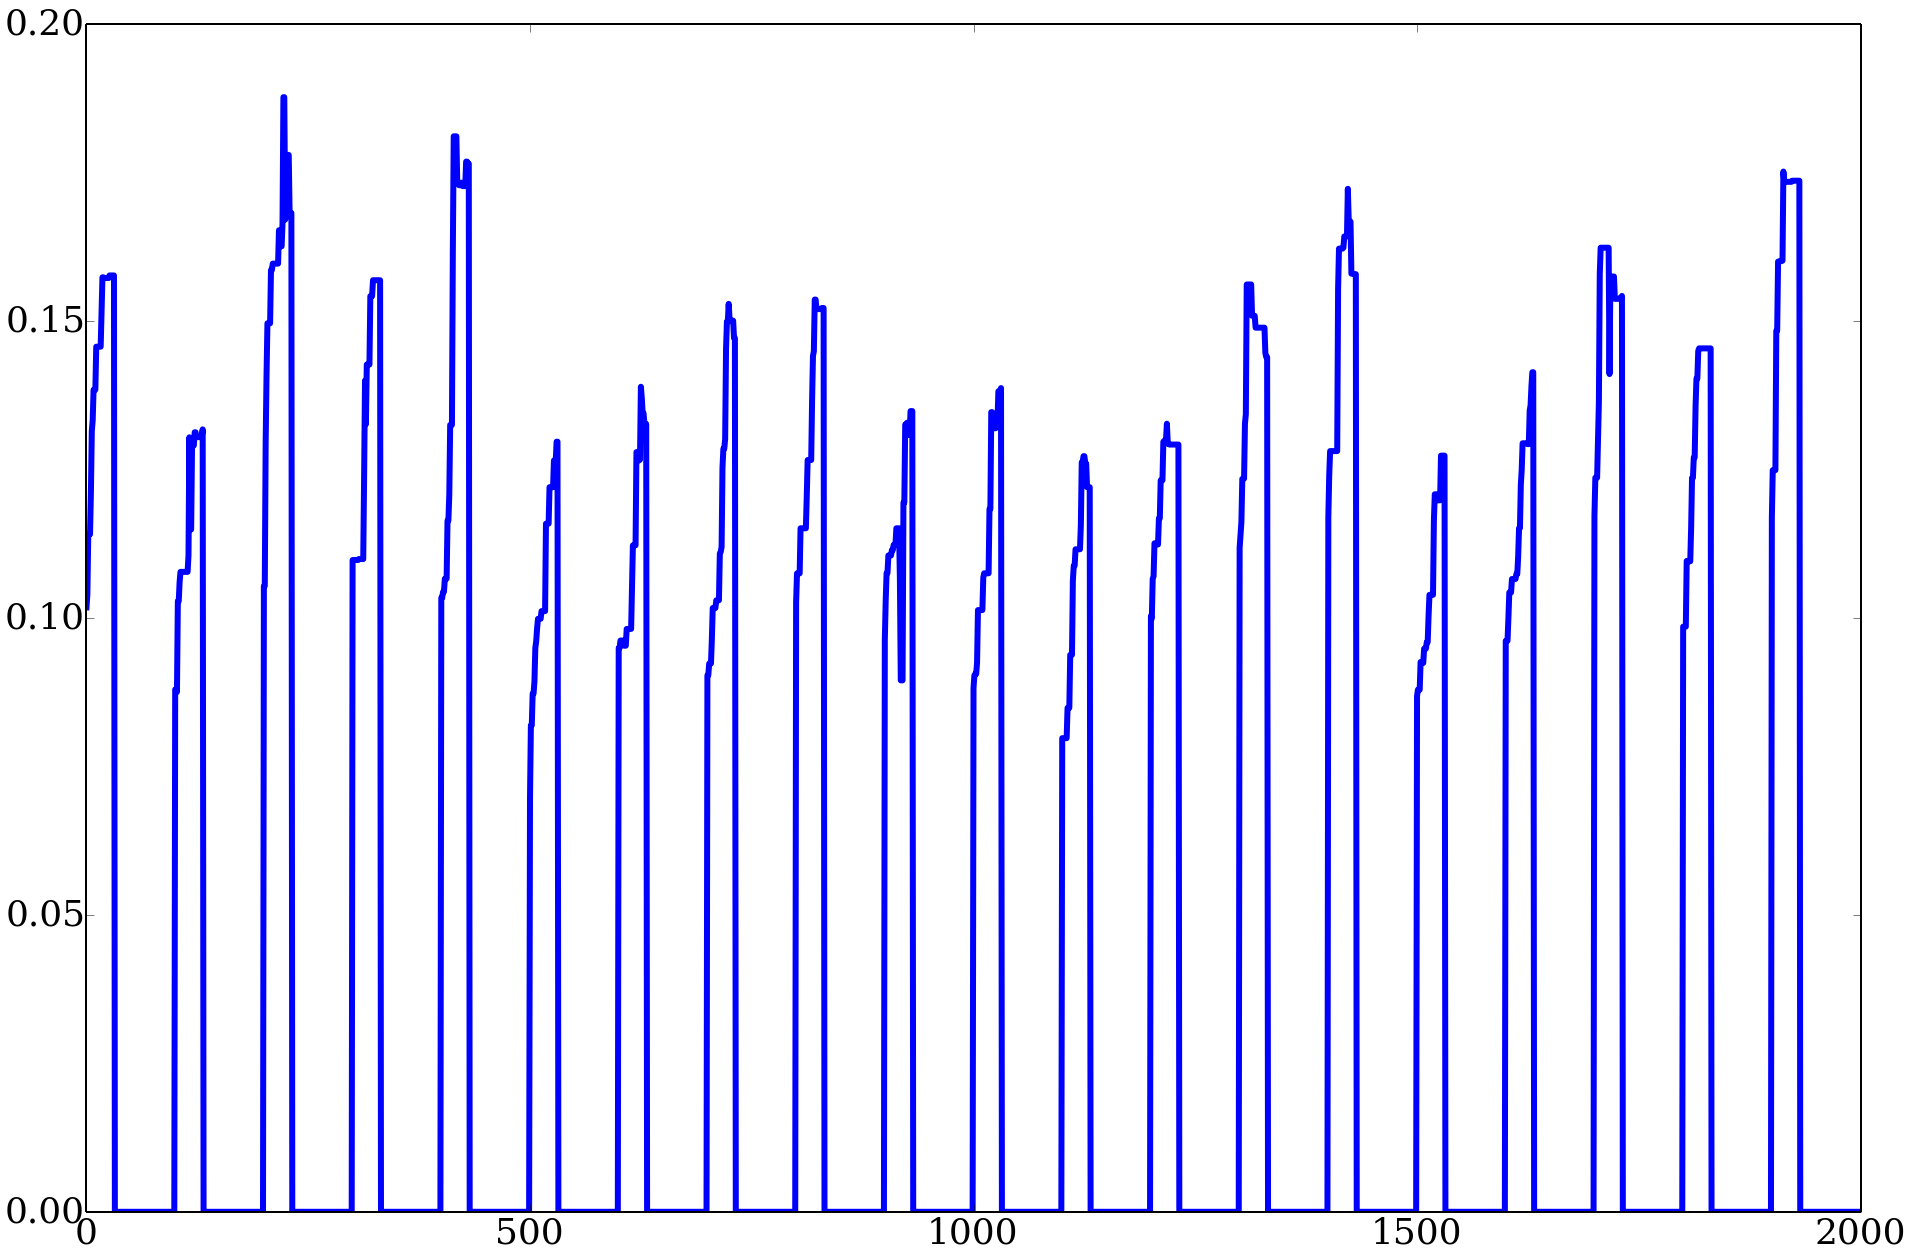

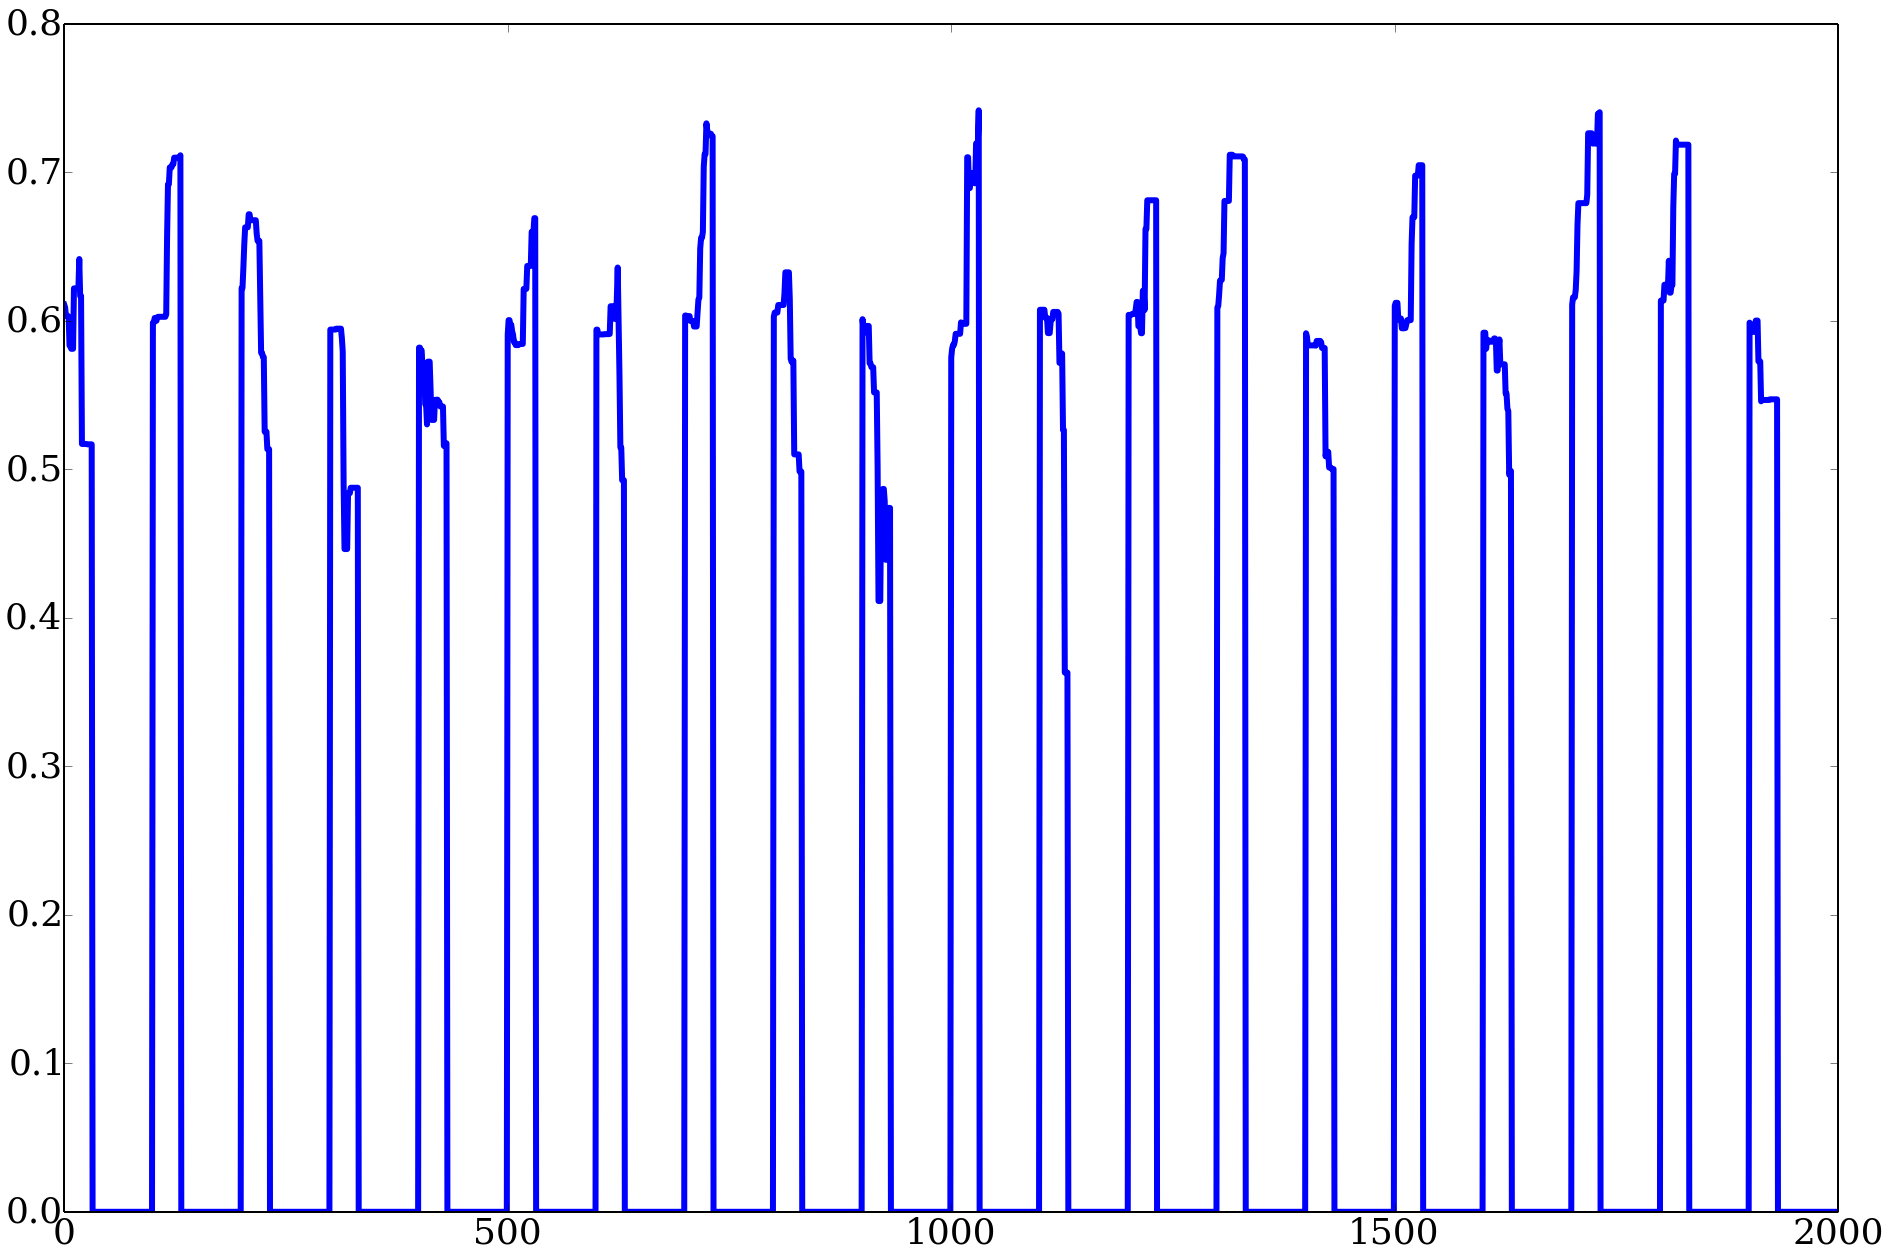

'\nimport corner\n#%matplotlib qt\nsamples = sampler.chain.reshape((-1, ndim))\nfig = corner.corner(samples, labels=["$gamma1$", "$sigma$"])\nfig.set_figwidth(32)\nfig.set_figheight(20)\n\nfig.tight_layout()\nfig.savefig(\'tmp.png\')\n'

In [181]:
print(pos)

#"""
print(np.transpose(pos)[0])

#samples = sampler.chain[:,:,:2].reshape((-1, 2))#[:, 50:, :].reshape((-1, ndim))

#print(samples)
plt.plot(sampler.chain[:,:,1].reshape(-1))
plt.show()
plt.plot(sampler.chain[:,:,0].reshape(-1))

plt.show()
"""
import corner
#%matplotlib qt
samples = sampler.chain.reshape((-1, ndim))
fig = corner.corner(samples, labels=["$gamma1$", "$sigma$"])
fig.set_figwidth(32)
fig.set_figheight(20)

fig.tight_layout()
fig.savefig('tmp.png')
"""